# DBSCAN 기본 코드

Density-based spatial clustering of Application Noise (밀도 기반 데이터 클러스터링 알고리즘)

클러스터의 개수를 미리 지정할 필요가 없다.

복잡한 형상의 데이터 셋에도 무리 없이 적용 가능

어떤 클래스에도 속하지 않는 포인트를 구분할 수 있다.

속도는 다소 느리다.

## #01. 준비작업

### [1] 패키지 가져오기

In [125]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from helper.util import *
from helper.plot import *
from hossam.analysis import *

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기 - 게임 유저 군집화

In [169]:
origin = my_read_excel("https://data.hossam.kr/mldata/game_usage.xlsx", info=False)


상위 5개 행
+----+--------------+--------------+
|    |   time spent |   game level |
|----+--------------+--------------|
|  0 |           39 |          944 |
|  1 |           55 |          705 |
|  2 |           29 |          757 |
|  3 |           59 |          999 |
|  4 |            7 |          109 |
+----+--------------+--------------+


## #02. 데이터 전처리

> DBSCAN은 성능이 데이터 스케일링에 매우 의존적이기 때문에 필수적으로 스케일링을 수행해야 한다.

### [1] 데이터 표준화

In [170]:
df = my_standard_scaler(origin)
df

,time spent,game level
0,-0.250733,1.474805
1,0.326494,0.606546
2,-0.611500,0.795456
3,0.470801,1.674613
4,-1.405187,-1.558652
...,...,...
95,0.037881,1.456640
96,0.146111,-0.192688
97,-1.188727,1.373084
98,1.192335,-1.100909


## #03. 군집화 모델 

### [1] 하이퍼파라미터 설정

| 하이퍼파라미터 | 설명 | 기본값 | 추천 | 가능한 값 |
|----------------|--------------------------------|--------|-----------------------------------------------------------|---------------------------|
| **`eps`**          | 최대 이웃 거리.                | `0.5`  | 밀도와 분포에 맞게 조정. **KNN 거리 그래프 사용 권장**.      | 양의 실수                 |
| **`min_samples`**  | `eps` 내 최소 이웃 수. 일반적으로 `minPts`라고 함 | `5`    | 밀도 기준에 맞게 조정. 특성 수보다 크게 설정 권장.        | 양의 정수                 |
| `metric`       | 거리 측정 방법.               | `'euclidean'` | 데이터 특성에 맞는 거리 측정 방식 선택. 'euclidean' 외에 직접 콜백함수 정의 가능       | 'cityblock', 'euclidean', 등 |
| `algorithm`    | 이웃 검색 알고리즘.           | `'auto'` | 데이터 크기/차원에 따라 `'kd_tree'`, `'ball_tree'`, `'brute'`, 선택. | `'kd_tree'`, `'ball_tree'`, `'brute'`, 등     |


In [171]:
# 모델 객체 생성
estimator = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)

# 모델 학습
estimator.fit(df)

# 예측 -> predict() 메서드가 없음
cluster = estimator.labels_
cluster

array([ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  1,  0,
        1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0])

### [2] 결과를 포함하는 데이터프레임 생성

In [172]:
df2 = df.copy()
df2['cluster'] = cluster
df2

,time spent,game level,cluster
0,-0.250733,1.474805,0
1,0.326494,0.606546,0
2,-0.611500,0.795456,0
3,0.470801,1.674613,0
4,-1.405187,-1.558652,1
...,...,...,...
95,0.037881,1.456640,0
96,0.146111,-0.192688,0
97,-1.188727,1.373084,0
98,1.192335,-1.100909,0


### [3] 결과 시각화

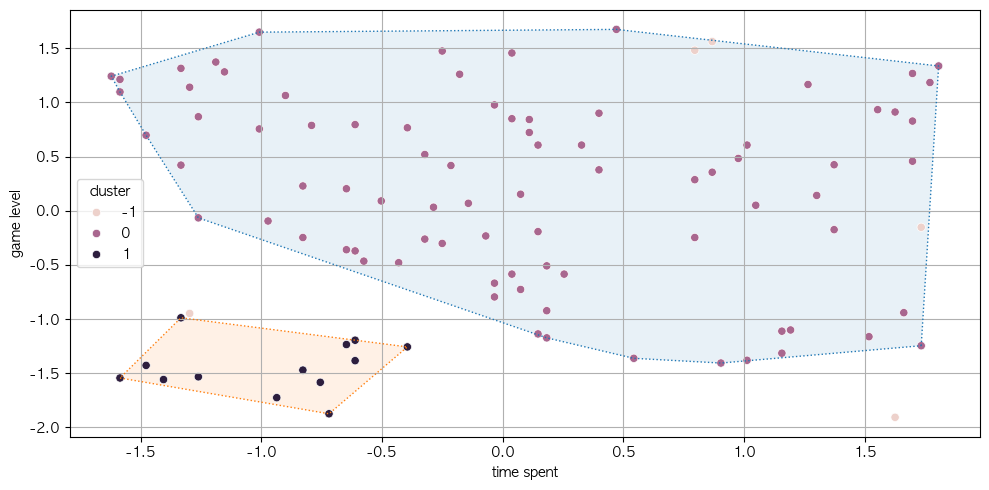

In [173]:
my_convex_hull(df2, xname='time spent', yname='game level', hue='cluster')

#### 분류 결과가 좀 이상하다...?

군집의 결과로 설정된 `label`값이 `-1`인 경우는 속한 집단이 없다고 해석해야 함.

해당 데이터포인트가 잡음(Noise)로 분류되었음을 의미함.

DBSCAN은 밀도 기반 클러스터링 알고리즘으로, 데이터 포인트들 사이의 밀집도를 기준으로 클러스터를 형성하는데 이 과정에서 일정 밀도 이상의 데이터 포인트들은 클러스터에 포함되지만, 그 기준을 만족하지 못하는 데이터 포인트들은 잡음으로 분류된다.

잡음으로 분류된 노이즈 데이터는 이상치로 해석할 수 있다. 이를 해결하기 위해 (1) 이상치 정제후 다시 수행하거나 (2) `eps`와 `minPts`파라미터를 조정하여 클러스터링 결과를 개선 해야 한다.

## #04. sorted-k-dist 그래프 (KNN 거리 그래프)

### [1] k개의 최근접 이웃 만들기

In [174]:
k = 5

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df)

# 한 점의 최근접 이웃 찾기
distance, indices = neighbors_fit.kneighbors(df)

#### 각 포인트별 거리

$k$값을 `5`로 설정했으므로 각 데이터 포인트별로 5개의 가까운 데이터와의 거리를 표현한다.

In [175]:
distance

array([[0.        , 0.22615872, 0.28918464, 0.54273855, 0.68828954],
       [0.        , 0.1803835 , 0.23997564, 0.24570226, 0.30298035],
       [0.        , 0.18052977, 0.21840257, 0.39442254, 0.39885068],
       [0.        , 0.37748709, 0.41251429, 0.48469813, 0.7486887 ],
       [0.        , 0.14653036, 0.14936701, 0.18096788, 0.49788041],
       [0.        , 0.21840257, 0.25735751, 0.39264415, 0.39744188],
       [0.        , 0.29007322, 0.4694834 , 0.49212437, 0.52346065],
       [0.        , 0.10111015, 0.12769295, 0.14503661, 0.3242889 ],
       [0.        , 0.05119875, 0.21735497, 0.38620494, 0.41680839],
       [0.        , 0.21001293, 0.21265306, 0.24922222, 0.33359719],
       [0.        , 0.32980129, 0.39427851, 0.46597237, 0.58478656],
       [0.        , 0.12867876, 0.28923923, 0.38608164, 0.40391511],
       [0.        , 0.0538374 , 0.18890987, 0.22509819, 0.35083572],
       [0.        , 0.1488094 , 0.23202731, 0.3100419 , 0.3561423 ],
       [0.        , 0.10767481, 0.

#### 가까운 순서대로 정렬

In [176]:
s_distance = np.sort(distance, axis=0)
s_distance

array([[0.        , 0.03768698, 0.10111015, 0.12715087, 0.2164602 ],
       [0.        , 0.03768698, 0.11039822, 0.14503661, 0.22405052],
       [0.        , 0.03768698, 0.11625223, 0.14619664, 0.23887731],
       [0.        , 0.03768698, 0.11988511, 0.14619664, 0.24570226],
       [0.        , 0.04632699, 0.12172144, 0.14620339, 0.24647088],
       [0.        , 0.04632699, 0.12285113, 0.16323203, 0.24744183],
       [0.        , 0.05119875, 0.12769295, 0.18096788, 0.24744183],
       [0.        , 0.05119875, 0.12769295, 0.18332275, 0.24922222],
       [0.        , 0.0538374 , 0.12836733, 0.19721127, 0.25104255],
       [0.        , 0.0538374 , 0.12836733, 0.20223342, 0.25104255],
       [0.        , 0.0538374 , 0.12836733, 0.21075165, 0.26638098],
       [0.        , 0.0538374 , 0.14619664, 0.21265306, 0.26638098],
       [0.        , 0.07251831, 0.14620339, 0.21735497, 0.268372  ],
       [0.        , 0.07251831, 0.14936701, 0.2227187 , 0.26908367],
       [0.        , 0.07537397, 0.

#### 각 데이터 포인트로부터의 거리

이 리스트 하나하나가 각각의 데이터 포인트를 의미

`eps`값은 가장 먼 데이터를 대상으로 측정한다.

> 마지막 데이터와의 거리($k-1$번째)만을 추출해서 1차원 리스트로 재구성하여 그래프의 y축으로 삼는다.

In [177]:
target = s_distance[:, k-1]
target

array([0.2164602 , 0.22405052, 0.23887731, 0.24570226, 0.24647088,
       0.24744183, 0.24744183, 0.24922222, 0.25104255, 0.25104255,
       0.26638098, 0.26638098, 0.268372  , 0.26908367, 0.26908367,
       0.27225354, 0.2748442 , 0.29286115, 0.2964667 , 0.29715156,
       0.29715156, 0.29761879, 0.30046542, 0.30298035, 0.3100419 ,
       0.31799381, 0.3242889 , 0.32980129, 0.33119465, 0.33284855,
       0.33284855, 0.33359719, 0.33359719, 0.33359719, 0.3361666 ,
       0.3361666 , 0.34025122, 0.35083572, 0.35448852, 0.3561423 ,
       0.36142489, 0.36326037, 0.36404794, 0.36404794, 0.36433447,
       0.36433447, 0.36433447, 0.37055397, 0.37748709, 0.37748709,
       0.38608164, 0.38777038, 0.38950658, 0.39053439, 0.39195543,
       0.39195543, 0.39442254, 0.39724802, 0.39744188, 0.39744188,
       0.39885068, 0.39885068, 0.40107801, 0.40391511, 0.40391511,
       0.40710388, 0.41680839, 0.41923149, 0.43543401, 0.44064273,
       0.4531205 , 0.46265961, 0.46408851, 0.46934873, 0.47121

#### 시각화 확인

x축에 데이터 포인트를 나열

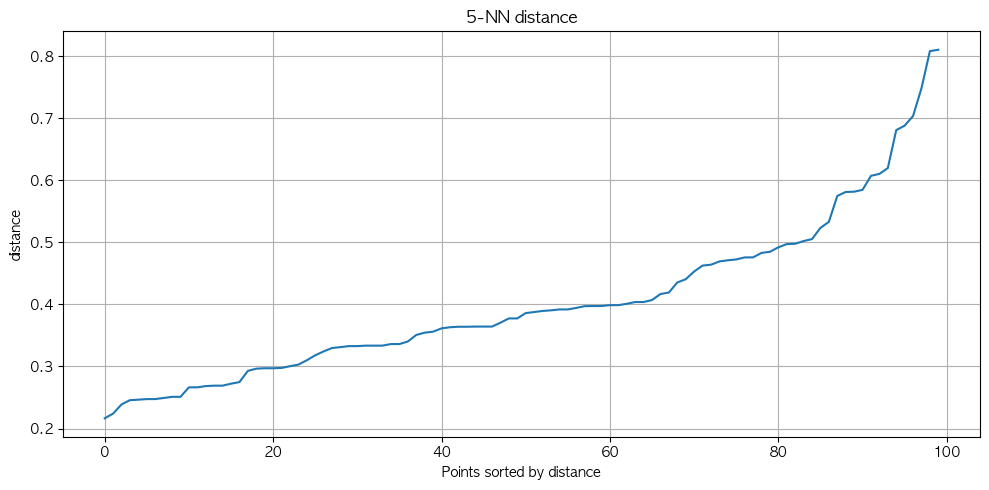

In [178]:
def plot_ex(ax):
    ax.set_title('%d-NN distance' % k)
    ax.set_ylabel('distance')
    ax.set_xlabel('Points sorted by distance')

my_lineplot(df=None, xname=range(0, len(target)), yname=target, callback=plot_ex)

### [2] eps 값 찾기

#### (1) 엘보우포인트 계산

In [179]:
kl = KneeLocator(range(0, len(target)), target, curve="convex", direction="increasing")
eps = kl.elbow_y
point = kl.elbow
print("found elbow: ", eps)
print("found point: ", point)

found elbow:  0.5847865649246538
found point:  90


#### (2) 엘보우 포인트를 포함한 시각화

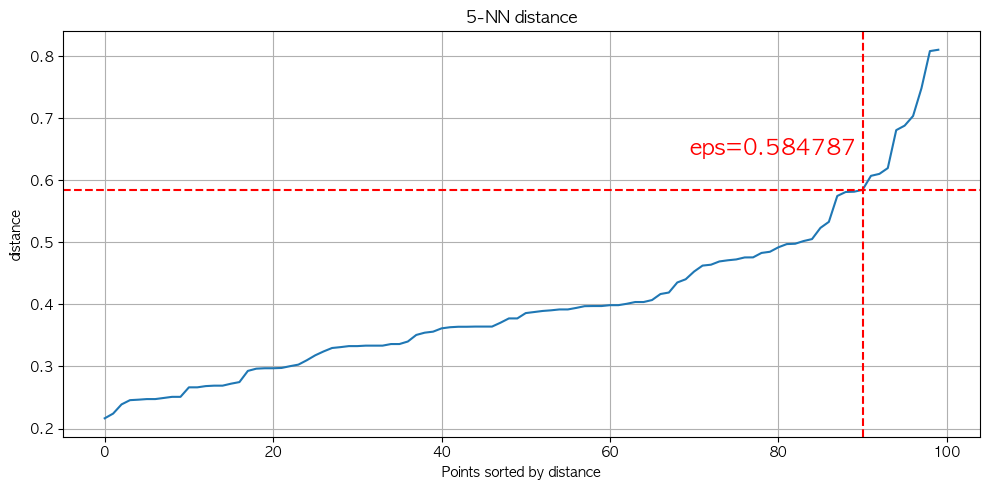

In [180]:
def hvline(ax):
    ax.set_title('%d-NN distance' % k)
    ax.set_ylabel('distance')
    ax.set_xlabel('Points sorted by distance')

    ax.axhline(eps, color='r', linestyle='--')
    ax.axvline(point, color='r', linestyle='--')
    ax.text(point, eps+0.05, 'eps=%f\t' % eps, fontsize=16, color='r', va='bottom', ha='right')

my_lineplot(df=None, xname=range(0, len(target)), yname=target, callback=hvline)

### [3] 결과를 기반으로 군집화 수행

`eps`는 시각화 결과를 통해 `0.56555`로 추정

`minPts`는 `k`값과 동일

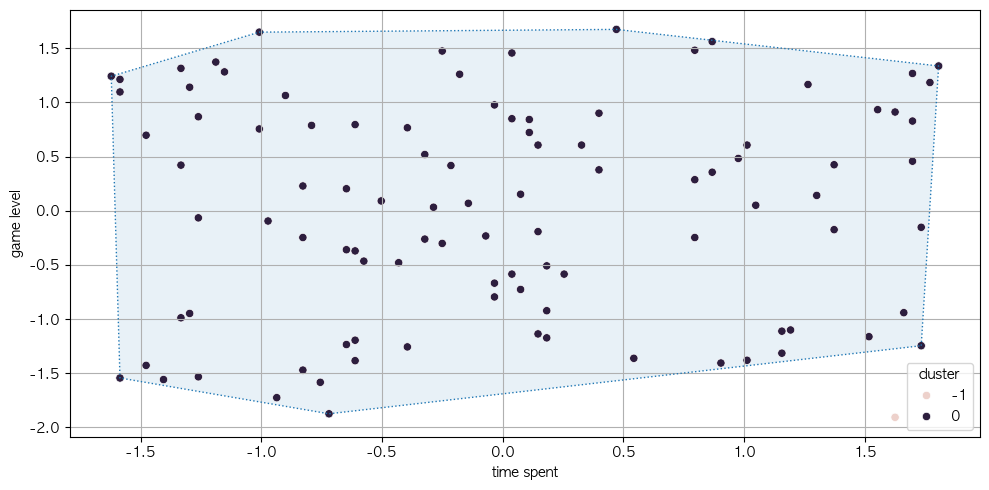

In [181]:
estimator = DBSCAN(eps=eps, min_samples=k, n_jobs=-1)
estimator.fit(df)

df2 = df.copy()
df2['cluster'] = estimator.labels_
my_convex_hull(df2, xname='time spent', yname='game level', hue='cluster')

### [4] k값을 2로 변경하여 재시도

#### (1) eps값 찾기

found elbow:  0.3298012850859778
found point:  93


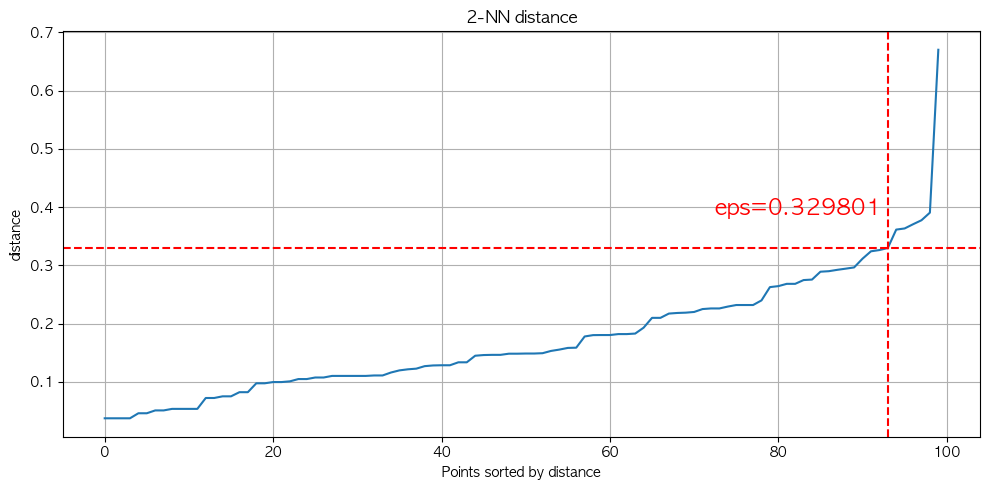

In [184]:
k = 2

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df)
distance, indices = neighbors_fit.kneighbors(df)

# 거리를 오름차순으로 정렬
s_distance = np.sort(distance, axis=0)
target = s_distance[:, k-1]

# eps 찾기
kl = KneeLocator(range(0, len(target)), target, curve="convex", direction="increasing")
eps = kl.elbow_y
point = kl.elbow
print("found elbow: ", eps)
print("found point: ", point)


my_lineplot(df=None, xname=range(0, len(target)), yname=target, callback=hvline)

#### (2) 군집화

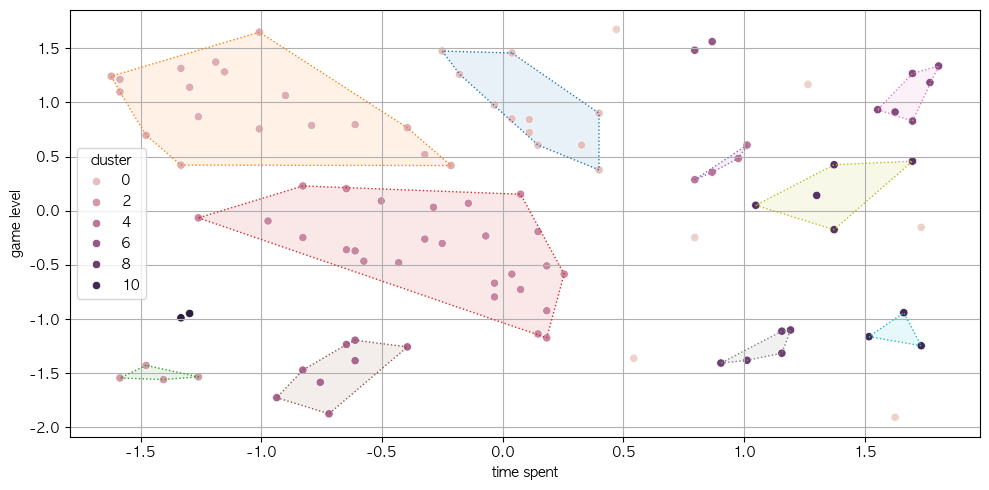

In [185]:
estimator = DBSCAN(eps=eps, min_samples=k, n_jobs=-1)
estimator.fit(df)

df2 = df.copy()
df2['cluster'] = estimator.labels_
my_convex_hull(df2, xname='time spent', yname='game level', hue='cluster')

> 이와 같이 k값을 변경해 가면서 eps지점을 확인하고 이를 DBSCAN에 반영하여 최적의 군집 형태를 찾아야 한다.